In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import KFold



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [42]:
df = pd.read_csv("./data.csv")

In [43]:
df = df.rename(columns={"tension_strenght": "tensile_strength"})

In [44]:
df

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7
5,0.02,10,40,honeycomb,200,60,40,pla,0,60,24,1.1
6,0.02,5,10,grid,205,65,40,pla,25,55,12,1.3
7,0.02,10,10,honeycomb,210,70,40,pla,50,21,14,1.5
8,0.02,9,70,grid,215,75,40,pla,75,24,27,1.4
9,0.02,8,40,honeycomb,220,80,40,pla,100,30,25,1.7


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tensile_strength    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [46]:
df.infill_pattern.value_counts()

infill_pattern
grid         25
honeycomb    25
Name: count, dtype: int64

In [47]:
df.material.value_counts()

material
abs    25
pla    25
Name: count, dtype: int64

In [48]:
for column in df.columns:
    print(str(column)+": "+str(df[column].unique()))
    print()

layer_height: [0.02 0.06 0.1  0.15 0.2 ]

wall_thickness: [ 8  7  1  4  6 10  5  9  2  3]

infill_density: [90 80 70 40 10 20 50 30 60]

infill_pattern: ['grid' 'honeycomb']

nozzle_temperature: [220 225 230 240 250 200 205 210 215]

bed_temperature: [60 65 70 75 80]

print_speed: [ 40  60 120]

material: ['abs' 'pla']

fan_speed: [  0  25  50  75 100]

roughness: [ 25  32  40  68  92  60  55  21  24  30  75 118 200 220 126 145  88  74
 120 144 265 312 368 180 176 128 138 121 168 154 225 289 326 192 212 172
 163 276 298 360 357 321 278 244]

tensile_strength: [18 16  8 10  5 24 12 14 27 25 37  9 23 26 33 29 19 11 34 13 22  4 35 28
 21 30]

elongation: [1.2 1.4 0.8 0.5 0.7 1.1 1.3 1.5 1.7 2.4 1.  2.2 1.9 1.6 2.1 2.  0.9 0.4
 1.8 2.9 0.6 2.8 2.3 3.3 3.1 2.7 3.2]



In [49]:
#In this data set, ABS and PLA assigned 0 and 1 values for materials (abs = 0, pla = 1)
df.material = [0 if each=='abs' else 1 for each in df.material]

#In this data set, grid and honeycomb assigned 0 and 1 values for infill_pattern (grid = 0, honeycomb = 1)
df.infill_pattern = [0 if each=='grid' else 1 for each in df.infill_pattern]

df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,0,220,60,40,0,0,25,18,1.2
1,0.02,7,90,1,225,65,40,0,25,32,16,1.4
2,0.02,1,80,0,230,70,40,0,50,40,8,0.8
3,0.02,4,70,1,240,75,40,0,75,68,10,0.5
4,0.02,6,90,0,250,80,40,0,100,92,5,0.7


In [50]:
df.layer_height = df.layer_height*100
df.elongation = df.elongation*100

In [51]:
target_cols = ['tensile_strength', 'roughness', 'elongation']
y = df[target_cols].values
x = df.drop(target_cols,axis=1).values

<Axes: xlabel='fan_speed', ylabel='tensile_strength'>

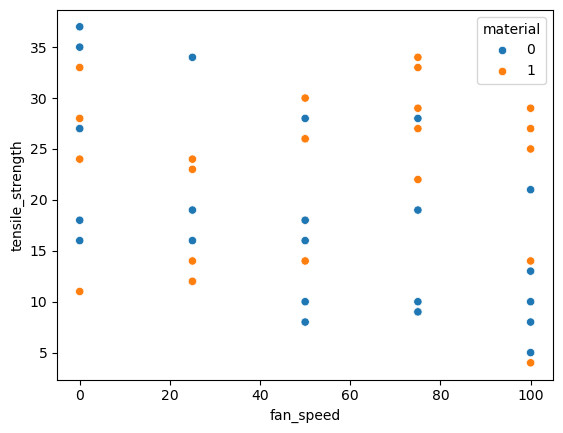

In [52]:
sns.scatterplot(x=df.fan_speed,y=df.tensile_strength,hue=df.material)

<Axes: xlabel='layer_height', ylabel='roughness'>

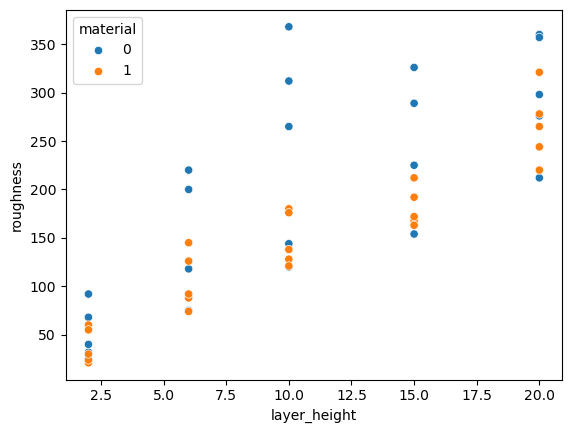

In [53]:
sns.scatterplot(x=df.layer_height,y=df.roughness,hue=df.material)

<Axes: xlabel='infill_pattern', ylabel='elongation'>

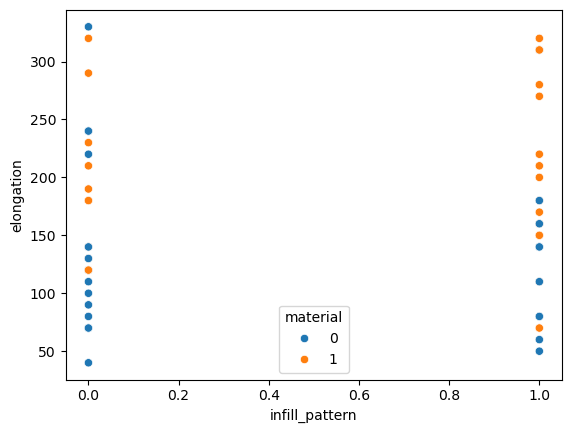

In [54]:
sns.scatterplot(x=df.infill_pattern,y=df.elongation,hue=df.material)

<Axes: xlabel='nozzle_temperature', ylabel='roughness'>

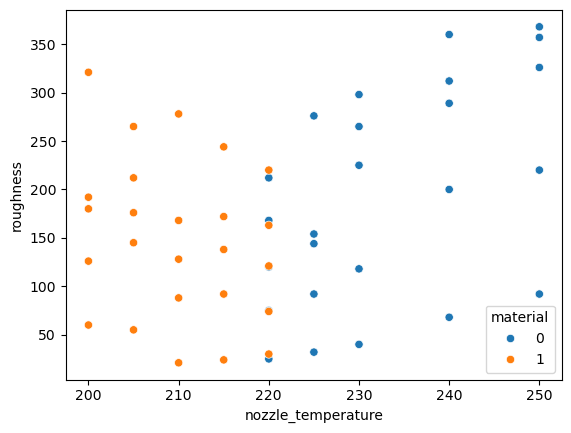

In [55]:
sns.scatterplot(x=df.nozzle_temperature,y=df.roughness,hue=df.material)

<Axes: xlabel='print_speed', ylabel='roughness'>

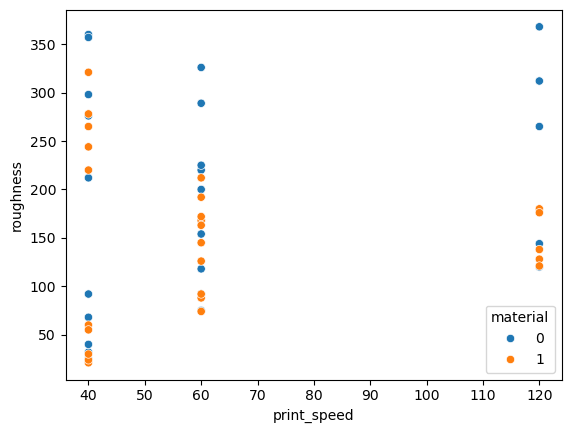

In [56]:
sns.scatterplot(x=df.print_speed,y=df.roughness,hue=df.material)

In [57]:


# Move to GPU if available
device = torch.device("cpu" )

x = torch.tensor(x, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

print("The input data x has shape of:",x.shape)
print("The target data y has shape of:",y.shape)

The input data x has shape of: torch.Size([50, 9])
The target data y has shape of: torch.Size([50, 3])


In [58]:
def strength_loss(output, y):
    criterion = nn.MSELoss()
    return criterion(output[:, 0], y[:, 0])

def rough_loss(output, y):
    criterion = nn.MSELoss()
    return criterion(output[:, 1], y[:, 1])  # Fix: return computed loss

def elongation_loss(output, y):
    criterion = nn.MSELoss()
    return criterion(output[:, 2], y[:, 2])  # Fix: return computed loss


In [59]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize the data using StandardScaler
scaler_x = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert the data to PyTorch tensors (no need to use .cuda() for CPU)
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create DataLoader
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=8, shuffle=False)




In [60]:
# Define a simple neural network for regression
class DNNRegressor(nn.Module):
    def __init__(self):
        super(DNNRegressor, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 3)  # Output layer (3 outputs for the targets)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = DNNRegressor()
criterion = nn.MSELoss()

In [61]:
import sys, copy
import numpy as np
import torch
import random
from torch.autograd import Variable

class One_Chain_Optimizer:
    def __init__(self, net, criterion, momentum=0.9, lr=0.1, wdecay=5e-4, T=0.05, total=50000):
        self.net = net
        self.eta = lr
        self.momentum = momentum
        self.T = T
        self.wdecay = wdecay
        self.V = 0.1
        self.velocity = []
        self.criterion = criterion
        self.total = total

        self.beta = 0.5 * self.V * self.eta
        self.alpha = 1 - self.momentum

        if self.beta > self.alpha:
            sys.exit('Momentum is too large')

        self.sigma = np.sqrt(2.0 * self.eta * (self.alpha - self.beta))
        self.scale = self.sigma * np.sqrt(self.T)

        for param in net.parameters():
            p = torch.zeros_like(param.data)
            self.velocity.append(p)

    def set_T(self, factor=1):
        self.T /= factor
        self.scale = self.sigma * np.sqrt(self.T)

    def set_eta(self, eta):
        self.eta = eta
        self.beta = 0.5 * self.V * self.eta
        self.sigma = np.sqrt(2.0 * self.eta * (self.alpha - self.beta))
        self.scale = self.sigma * np.sqrt(self.T)

    def backprop(self, x, y):
        self.net.zero_grad()
        """ convert mean loss to sum losses """
        loss = self.criterion(self.net(x), y) #* self.total
        loss.backward()
        return loss

    def step(self, x, y):
      loss = self.backprop(x, y)

      # Gradient clipping to prevent exploding gradients
      torch.nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=1.0)

      for i, param in enumerate(self.net.parameters()):
          # Create proposal noise tensor with up-to-date method
          proposal = torch.normal(0, self.scale, size=param.data.size(), device=param.data.device)

          grads = param.grad.data

          # Log parameters and gradients for debugging


          if self.wdecay != 0:
              grads.add_(self.wdecay, param.data)

          self.velocity[i].mul_(self.momentum).add_(-self.eta, grads).add_(proposal)
          param.data.add_(self.velocity[i])

      return loss.data.item()

In [62]:
import math
import copy
import sys
import os
import time
import csv
import argparse
import random
import collections
from random import shuffle
import pickle

from tqdm import tqdm ## better progressbar
from math import exp
from sys import getsizeof
import numpy as np

## import pytorch modules
import torch
from torch.autograd import Variable
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.utils.data as data
import torchvision.datasets as datasets

CUDA_EXISTS = torch.cuda.is_available()
device = torch.device("cpu" )

# Define Your own Parameters in parameters : parameters = [T, lr, num_of_chains, wdecay, total, Tgap, LRgap, num_epoch, period, batch, var_reduce, adapt_c, alpha, bias_F, cool, burn, Tanneal, LRanneal]
# T:Temperature for high temperature chain, default=0.05
# lr: Sampling learning rate, default=0.1
# num_of_chains: Total number of chains, default=1
# wdecay: Samling weight decay, default=5e-4
# total: Total data points, default=50000
# Tgap: Temperature gap between chains, default=0.2
# LRgap: Learning rate gap between chains, default=0.66
# num_epoch: Sampling Epochs, default=1000
# period: estimate adaptive variance every [period] epochs, default=2
# batch: Batch size, default=256
# var_reduce: n>0 means update variance reduction every n epochs; n divides 10, default=0
# adapt_c: adapt_c=1 is equivalent to running Alg. 2 in the appendix, default=0
# alpha: forgetting rate, default=0.3
# bias_F: correction factor F, default=1.5e5
# cool: No swaps happen during the cooling time after a swap, default=1
# burn: burn in iterations for sampling (sn * burn), default=0.6
# Tanneal: temperature annealing factor, default=1.02
# LRanneal: lr annealing factor, default=0.984

def trainer(nets, training_data, parameters):
  # Loss function
  criterion = nn.MSELoss()
  # Initial temperature and learning rate
  init_T, init_lr = parameters.T, parameters.lr

  chains, lr_set, myVars, cooling_time, BMAS = {}, [], [], [], []
  for idx in range(parameters.num_of_chains-1, -1, -1):
    print('Chain {} Initial learning rate {:.2e} temperature {:.2e}'.format(idx, init_lr, init_T))
    chain = One_Chain_Optimizer(nets[idx], criterion, lr=init_lr, wdecay=parameters.wdecay, T=init_T, total=parameters.total)
    lr_set.insert(0, init_lr)
    init_T /= parameters.Tgap
    init_lr /= parameters.LRgap
    chains[idx] = chain
    myVars.append(sys.float_info.max)

  start = time.time()
  counter, warm_up, adjusted_corrections = 1., 10, 0
  # Initialization for variance reduction
  last_full_losses, last_VRnets, corr = [0] * parameters.num_of_chains, [], [-1] * parameters.num_of_chains
  for idx in range(parameters.num_of_chains):
    last_VRnets.append(pickle.loads(pickle.dumps(nets[idx])))

  for epoch in range(parameters.num_epoch):
    # Update adaptive variance and variance reduction every [period] epochs
    if parameters.period > 0 and epoch % parameters.period ==0:
      cur_full_losses = [0] * parameters.num_of_chains
      for idx in range(parameters.num_of_chains):
        stage_losses, cv_losses = [], []
        nets[idx].eval()
        for i, (x_batch, y_batch) in enumerate(training_data):
          x_batch = x_batch.to(device)
          y_batch = y_batch.to(device)
          nets[idx].zero_grad()
          avg_loss = criterion(nets[idx](x_batch), y_batch).item()
          cur_full_losses[idx] += avg_loss * parameters.batch
          stage_losses.append(avg_loss * parameters.total)
          if parameters.var_reduce:
            cv_losses.append(criterion(last_VRnets[idx](x_batch), y_batch).item() * parameters.total)

          if parameters.adapt_c:
            adaptive_corr = -np.cov(stage_losses, cv_losses, ddof=1)[0][1] / np.var(cv_losses, ddof=1)
            corr[idx] = (1 - parameters.alpha) * corr[idx] + parameters.alpha * adaptive_corr

          if parameters.var_reduce:
            for i in range(len(stage_losses)):
              stage_losses[i] = stage_losses[i] + corr[idx] * (cv_losses[i] - np.mean(cv_losses))

        std_epoch = np.std(stage_losses, ddof=1)
        myVars[idx] = 0.5 * std_epoch**2 if myVars[idx] == sys.float_info.max else ((1 - parameters.alpha) * myVars[idx] + parameters.alpha * 0.5 * std_epoch ** 2)
        print('Epoch {} Chain {} loss std {:.2e} variance {:.2e} smooth variance {:.2e} adaptive c {:.2f}'.format(epoch, idx, std_epoch, 0.5 * std_epoch**2, myVars[idx], corr[idx]))
        last_VRnets[idx] = pickle.loads(pickle.dumps(nets[idx]))
        last_full_losses[idx] = cur_full_losses[idx]

    for idx in range(parameters.num_of_chains):
      nets[idx].train()

    for i, (x_batch, y_batch) in enumerate(training_data):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      counter += 1
      loss_chains = []
      for idx in range(parameters.num_of_chains):
        loss = chains[idx].step(x_batch, y_batch)
        print(f' Loss: {loss:.6f}')
        # variance-reduced negative log posterior
        if parameters.var_reduce and epoch > warm_up:
          control_variate_loss = criterion(last_VRnets[idx](x), y).item() * parameters.total
          loss = loss + corr[idx] * (control_variate_loss - last_full_losses[idx])
        loss_chains.append(loss)

      # Swap
      for idx in range(parameters.num_of_chains - 1):
        # exponential average smoothing
        delta_invT = 1. / chains[idx].T - 1. / chains[idx+1].T
        adjusted_corrections = delta_invT * (myVars[idx] + myVars[idx+1]) / parameters.bias_F
        if np.log(np.random.uniform(0, 1)) < delta_invT * (loss_chains[idx] - loss_chains[idx+1] - adjusted_corrections):
          if epoch not in cooling_time:
            temporary = pickle.loads(pickle.dumps(chains[idx+1].net))
            chains[idx+1].net.load_state_dict(chains[idx].net.state_dict())
            chains[idx].net.load_state_dict(temporary.state_dict())
            print('Epoch {} Swap chain {} with chain {} and increased F {:0.2e}'.format(epoch, idx, idx+1, parameters.bias_F))
            cooling_time = range(epoch, epoch+parameters.cool)
          else:
            print('Epoch {} Cooling period'.format(epoch))

    # Anneaing
    if epoch < parameters.burn * parameters.num_epoch:
      parameters.bias_F *= parameters.Tanneal
    for idx in range(parameters.num_of_chains):
      if epoch > 0.4 * parameters.num_epoch and parameters.LRanneal <=1:
        chains[idx].eta *= parameters.LRanneal
      if epoch < parameters.burn * parameters.num_epoch:
        chains[idx].set_T(parameters.Tanneal)
    
    

      # add test set here
      ##########################################

  end = time.time()
  print('Time used {:.2f}s'.format(end - start))

In [67]:
class Parameters:
    T = 0.01
    lr = 2e-4
    num_of_chains = 2
    wdecay = 5e-4
    total = 10000  # Adjust based on dataset size
    Tgap = 0.2
    LRgap = 0.66
    num_epoch = 3000
    period = 2
    batch = 256
    var_reduce = 0
    adapt_c = 0
    alpha = 0.3
    bias_F = 1.5e5
    cool = 1
    burn = 0.6
    Tanneal = 1.02
    LRanneal = 0.984

params = Parameters()

# Create multiple chains (models)
nets = [DNNRegressor() for _ in range(params.num_of_chains)]

# Train using Replica Exchange
trainer(nets, train_loader, params)

Chain 1 Initial learning rate 2.00e-04 temperature 1.00e-02
Chain 0 Initial learning rate 3.03e-04 temperature 5.00e-02
Epoch 0 Chain 0 loss std 2.85e+03 variance 4.05e+06 smooth variance 4.05e+06 adaptive c -1.00
Epoch 0 Chain 1 loss std 3.28e+03 variance 5.39e+06 smooth variance 5.39e+06 adaptive c -1.00
 Loss: 1.053639
 Loss: 1.117700
 Loss: 0.763171
 Loss: 0.750334
 Loss: 1.260399
 Loss: 1.252624
 Loss: 0.623750
 Loss: 0.609316
 Loss: 1.349787
 Loss: 1.337288
 Loss: 0.680591
 Loss: 0.623969
 Loss: 1.219746
 Loss: 1.266329
 Loss: 1.110077
 Loss: 1.123320
 Loss: 1.139821
 Loss: 1.201148
 Loss: 0.875206
 Loss: 0.848316
Epoch 2 Chain 0 loss std 3.12e+03 variance 4.85e+06 smooth variance 4.29e+06 adaptive c -1.00
Epoch 2 Chain 1 loss std 2.84e+03 variance 4.04e+06 smooth variance 4.98e+06 adaptive c -1.00
 Loss: 1.137295
 Loss: 1.118930
 Loss: 1.070874
 Loss: 1.104286
 Loss: 0.620008
 Loss: 0.626315
 Loss: 1.096253
 Loss: 1.121507
 Loss: 1.089680
 Loss: 1.097206
 Loss: 0.778783
 Loss: 0

In [68]:
# Testing loop
nets[0].eval()
test_loss = 0.0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred = nets[0](x_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()

# Print test loss
print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# Make predictions for the test set
with torch.no_grad():
    y_test_pred = nets[0](x_test_tensor)

# Inverse transform the predictions and true values back to original scale
y_test_pred = scaler_y.inverse_transform(y_test_pred.numpy())  # Convert to numpy
y_test = scaler_y.inverse_transform(y_test_tensor.numpy())  # Convert to numpy

# Print first few predictions and true values
print("Predictions for test set:")
print(y_test_pred[:10])
print("True values for test set:")
print(y_test[:10])


Test Loss: 0.4991
Predictions for test set:
[[ 17.593515 275.22482   49.40867 ]
 [ 10.09407  256.58386   87.29531 ]
 [ 25.355549 196.27771  200.56403 ]
 [ 31.563593 448.61096  184.61217 ]
 [ 19.785938   9.798447 174.51738 ]
 [ 32.926853 217.86102  231.10056 ]
 [ 15.444226 229.64482  113.46571 ]
 [ 22.61806  -17.832626 231.54088 ]
 [ 19.389854 189.3818   151.5189  ]
 [ 26.36528  209.93726  228.96655 ]]
True values for test set:
[[  9.        200.         80.       ]
 [  4.0000005 163.         70.       ]
 [ 27.        168.        240.       ]
 [ 28.        321.        270.       ]
 [ 26.         88.        160.       ]
 [ 29.        244.        320.       ]
 [ 12.        176.        120.       ]
 [ 11.        180.        160.       ]
 [ 18.        225.        140.       ]
 [ 29.         74.        200.       ]]


In [69]:
# Testing loop
nets[1].eval()
test_loss = 0.0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred = nets[1](x_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()

# Print test loss
print(f'Test Loss: {test_loss/len(test_loader):.4f}')

# Make predictions for the test set
with torch.no_grad():
    y_test_pred = nets[1](x_test_tensor)

# Inverse transform the predictions and true values back to original scale
y_test_pred = scaler_y.inverse_transform(y_test_pred.numpy())  # Convert to numpy
y_test = scaler_y.inverse_transform(y_test_tensor.numpy())  # Convert to numpy

# Print first few predictions and true values
print("Predictions for test set:")
print(y_test_pred[:10])
print("True values for test set:")
print(y_test[:10])


Test Loss: 0.3959
Predictions for test set:
[[ 11.945619 128.15623  102.99774 ]
 [ 17.460901 133.03955  204.22476 ]
 [ 29.041254 141.10402  227.03519 ]
 [ 32.624077 279.21582  314.49896 ]
 [ 19.082756  88.85163  148.95969 ]
 [ 26.150257 221.139    235.27725 ]
 [ 27.372606 134.62715  218.7594  ]
 [ 21.61272  125.250145 170.83461 ]
 [ 22.736105 241.2504   161.32562 ]
 [ 23.296679  62.78354  187.37979 ]]
True values for test set:
[[  9.        200.         80.       ]
 [  4.0000005 163.         70.       ]
 [ 27.        168.        240.       ]
 [ 28.        321.        270.       ]
 [ 26.         88.        160.       ]
 [ 29.        244.        320.       ]
 [ 12.        176.        120.       ]
 [ 11.        180.        160.       ]
 [ 18.        225.        140.       ]
 [ 29.         74.        200.       ]]
